In [253]:
import os
from collections import OrderedDict
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
from torchsummary import summary
import time
%matplotlib inline

In [254]:
# read it in to inspect it
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [255]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [256]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [257]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [258]:
# let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [259]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device = "cpu" # MPS seems slower???
print(f"Using {device} device")

Using cpu device


In [260]:
data = data.to(device)

In [261]:
batch_size = 16
embedding_vec_size = 64
hidden_size = embedding_vec_size * 4
context_size = 32
num_heads = 4
head_size = embedding_vec_size // num_heads
num_transformer_blocks = 4
dropout = 0.1

In [262]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [263]:
torch.manual_seed(1337)

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_size, (batch_size,))
    x = torch.stack([data[i:i+context_size] for i in ix])
    y = torch.stack([data[i+1:i+context_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(context_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([16, 32])
tensor([[58, 53,  1, 41, 53, 56, 56, 59, 54, 58,  1, 39,  1, 51, 39, 52,  5, 57,
          1, 61, 47, 44, 43,  1, 47, 57,  0, 61, 46, 43, 52,  1],
        [49,  1, 39, 52,  1, 53, 39, 58, 46,  1, 40, 63,  1, 20, 47, 51,  6,  0,
         32, 46, 43,  1, 59, 52, 47, 58, 63,  1, 58, 46, 43,  1],
        [59, 50, 42,  1, 58, 46, 53, 59,  1, 61, 43, 56, 58,  1, 57, 53,  1, 58,
         53, 53,  2,  0,  0, 24, 33, 15, 21, 27, 10,  0, 35, 43],
        [ 8,  0,  0, 35, 13, 30, 35, 21, 15, 23, 10,  0, 28, 56, 53, 60, 43,  1,
         47, 58,  6,  1, 20, 43, 52, 56, 63,  6,  1, 39, 52, 42],
        [58,  1, 57, 46, 43,  8,  0,  0, 32, 30, 13, 26, 21, 27, 10,  0, 18, 53,
         56,  1, 61, 46, 39, 58,  1, 56, 43, 39, 57, 53, 52,  6],
        [56, 61, 47, 41, 49,  6,  1, 50, 43, 58,  1, 47, 58,  1, 40, 43, 11,  0,
         18, 53, 56,  1, 47, 52,  1, 58, 46, 63,  1, 57, 46, 53],
        [25, 10,  0, 35, 47, 58, 46, 42, 56, 39, 61,  1, 63, 53, 59,  1, 46, 43,
        

In [264]:
print(xb) # our input to the transformer

tensor([[58, 53,  1, 41, 53, 56, 56, 59, 54, 58,  1, 39,  1, 51, 39, 52,  5, 57,
          1, 61, 47, 44, 43,  1, 47, 57,  0, 61, 46, 43, 52,  1],
        [49,  1, 39, 52,  1, 53, 39, 58, 46,  1, 40, 63,  1, 20, 47, 51,  6,  0,
         32, 46, 43,  1, 59, 52, 47, 58, 63,  1, 58, 46, 43,  1],
        [59, 50, 42,  1, 58, 46, 53, 59,  1, 61, 43, 56, 58,  1, 57, 53,  1, 58,
         53, 53,  2,  0,  0, 24, 33, 15, 21, 27, 10,  0, 35, 43],
        [ 8,  0,  0, 35, 13, 30, 35, 21, 15, 23, 10,  0, 28, 56, 53, 60, 43,  1,
         47, 58,  6,  1, 20, 43, 52, 56, 63,  6,  1, 39, 52, 42],
        [58,  1, 57, 46, 43,  8,  0,  0, 32, 30, 13, 26, 21, 27, 10,  0, 18, 53,
         56,  1, 61, 46, 39, 58,  1, 56, 43, 39, 57, 53, 52,  6],
        [56, 61, 47, 41, 49,  6,  1, 50, 43, 58,  1, 47, 58,  1, 40, 43, 11,  0,
         18, 53, 56,  1, 47, 52,  1, 58, 46, 63,  1, 57, 46, 53],
        [25, 10,  0, 35, 47, 58, 46, 42, 56, 39, 61,  1, 63, 53, 59,  1, 46, 43,
         52, 41, 43,  6,  1, 51, 63, 

In [265]:
# # self attention experimentation
# torch.manual_seed(1337)
# B, T, C = 4, 8, 32
# x = torch.randn(B, T, C)

# head_size = 16
# query_mod = nn.Linear(C, head_size, bias=False)
# key_mod = nn.Linear(C, head_size, bias=False)
# value_mod = nn.Linear(C, head_size, bias=False)

# query = query_mod(x)
# key = key_mod(x)
# value = value_mod(x)

# scores = query @ key.swapaxes(1, 2)
# scores.masked_fill_(torch.ones((T, T)).tril() == 0., float('-inf'))
# probs_mod = nn.Softmax(-1)
# probs = probs_mod(scores)
# out = probs @ value

In [266]:
# x = torch.randint(vocab_size, (batch_size, context_size))
# x = nn.Embedding(vocab_size, embedding_vec_size)(x)
# query_mod = nn.Linear(embedding_vec_size, head_size, bias=False)
# key_mod = nn.Linear(embedding_vec_size, head_size, bias=False)
# value_mod = nn.Linear(embedding_vec_size, head_size, bias=False)
# query = query_mod(x)
# key = key_mod(x)
# value = value_mod(x)
# query.shape, key.shape, value.shape

In [272]:
class SelfAttentionHead(nn.Module):
    
    def __init__(self, input_vec_size, head_size):
        super().__init__()
        self.query = nn.Linear(input_vec_size, head_size, bias=False)
        self.key = nn.Linear(input_vec_size, head_size, bias=False)
        self.value = nn.Linear(input_vec_size, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, T, C = x.shape
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        scores = (query @ key.swapaxes(1, 2)) / C**0.5
        scores.masked_fill_(torch.ones((T, T)).tril().to(device) == 0., float('-inf'))
        probs = F.softmax(scores, dim=-1)
        probs = self.dropout(probs)
        out = probs @ value
        return out
    
    
class MultiHead(nn.Module):
    
    def __init__(self, input_vec_size, num_heads, head_size):
        super().__init__()
        assert input_vec_size == (num_heads * head_size)
        self.self_attention_heads = nn.ModuleList(
            [SelfAttentionHead(input_vec_size, head_size) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(input_vec_size, input_vec_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = torch.cat([h(x) for h in self.self_attention_heads], dim=-1)
        out = self.dropout(self.proj(x))
        return out


class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.nonlinear = nn.ReLU()
        self.proj = nn.Linear(hidden_size, input_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.nonlinear(self.linear(x))
        x = self.dropout(self.proj(x))
        return x

    
class TransformerBlock(nn.Module):
    
    def __init__(self, embedding_vec_size, num_heads, head_size, hidden_size):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(embedding_vec_size)
        self.multi_head = MultiHead(embedding_vec_size, num_heads, head_size)
        self.layernorm2 = nn.LayerNorm(num_heads * head_size)
        self.mlp = MLP(num_heads * head_size, hidden_size)
        
    def forward(self, x):
        x = x + self.multi_head(self.layernorm1(x))
        x = x + self.mlp(self.layernorm2(x))
        return x


class TransformerLanguageModel(nn.Module):

    def __init__(self, vocab_size, embedding_vec_size, head_size, context_size, hidden_size):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_vec_size)
        self.pos_embedding = nn.Embedding(context_size, embedding_vec_size)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(embedding_vec_size, num_heads, head_size, hidden_size) for _ in range(num_transformer_blocks)]
        )
        self.layernorm = nn.LayerNorm(embedding_vec_size)
        self.output_linear = nn.Linear(embedding_vec_size, vocab_size)
        
    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape
        assert T <= self.pos_embedding.weight.shape[0]
        x = self.token_embedding(idx) + self.pos_embedding(torch.arange(T).to(device))
        x = self.transformer_blocks(x)
        x = self.layernorm(x)
        logits = self.output_linear(x)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens):
        B, T = idx.shape
        context_size = self.pos_embedding.weight.shape[0]
        assert B == 1
        assert T <= context_size
        
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # Truncate input to model if needed
            x = idx if idx.shape[1] <= context_size else idx[:, -context_size:]
            
            # get the predictions
            logits, loss = self(x)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = TransformerLanguageModel(vocab_size, embedding_vec_size, head_size, context_size, hidden_size)
model = model.to(device)

with torch.no_grad():
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    print(logits.shape)
    print(loss)
    
numparams = sum([p.numel() for p in model.parameters()])
print(f"Number of params: {numparams}")

print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=100)[0].tolist()))


torch.Size([1024, 65])
tensor(4.3313)
Number of params: 209729

:D'
:vPFtz.rVG:Au,gEde-pbWqGu&elI lyvCHKEWMVx3dkVsaZSDDXYHo3'3pSCubSGsDK?TaB
Ag!ThvcDZjkVQ 3KuFA.?Dq


In [273]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [274]:
eval_iters = 200

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [280]:
torch.manual_seed(1337)

start_time = time.time()

losses_train = []
losses_val = []
max_steps = 100000
for steps in range(max_steps): # increase number of steps for good results... 
    
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # track stats
    if steps % 1000 == 0:
        estimated_loss = estimate_loss()
        losses_train.append(estimated_loss['train'])
        losses_val.append(estimated_loss['val'])
    if steps % 1000 == 0: # print every once in a while
        print(f'{steps:7d}/{max_steps:7d}: {losses_train[-1]:.4f} / {losses_val[-1]:.4f}')

estimated_loss = estimate_loss()
print(f'{steps:7d}/{max_steps:7d}: {estimated_loss["train"]:.4f} / {estimated_loss["val"]:.4f}')

end_time = time.time()
print(f"Training time: {end_time - start_time}")

      0/ 100000: 1.5536 / 1.7417
   1000/ 100000: 1.5445 / 1.7089
   2000/ 100000: 1.5294 / 1.7076
   3000/ 100000: 1.5247 / 1.6998
   4000/ 100000: 1.5184 / 1.7016
   5000/ 100000: 1.5134 / 1.6854
   6000/ 100000: 1.5071 / 1.6864
   7000/ 100000: 1.4953 / 1.6858
   8000/ 100000: 1.4986 / 1.6768
   9000/ 100000: 1.4967 / 1.6771
  10000/ 100000: 1.4880 / 1.6678
  11000/ 100000: 1.4871 / 1.6622
  12000/ 100000: 1.4779 / 1.6589
  13000/ 100000: 1.4785 / 1.6666
  14000/ 100000: 1.4695 / 1.6674
  15000/ 100000: 1.4775 / 1.6601
  16000/ 100000: 1.4712 / 1.6533
  17000/ 100000: 1.4733 / 1.6458
  18000/ 100000: 1.4676 / 1.6488
  19000/ 100000: 1.4619 / 1.6689
  20000/ 100000: 1.4643 / 1.6616
  21000/ 100000: 1.4559 / 1.6497
  22000/ 100000: 1.4533 / 1.6430
  23000/ 100000: 1.4528 / 1.6544
  24000/ 100000: 1.4608 / 1.6322
  25000/ 100000: 1.4576 / 1.6448
  26000/ 100000: 1.4475 / 1.6447
  27000/ 100000: 1.4526 / 1.6357
  28000/ 100000: 1.4483 / 1.6428
  29000/ 100000: 1.4438 / 1.6327
  30000/ 1

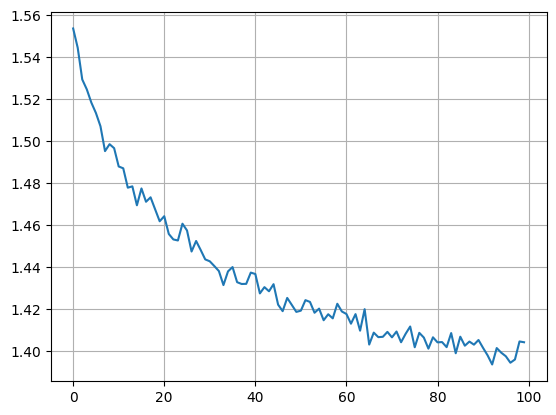

In [283]:
plt.plot(losses_train)
plt.grid()

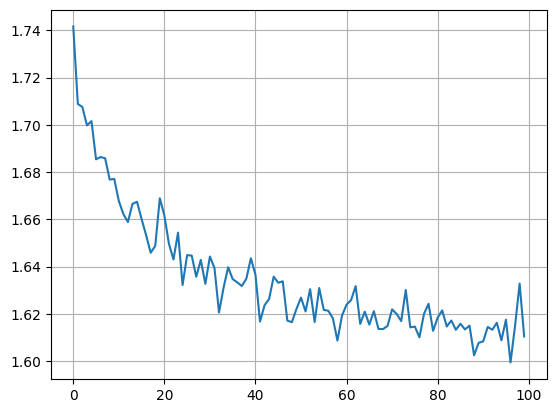

In [284]:
plt.plot(losses_val)
plt.grid()

In [288]:
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=500)[0].tolist()))


Edward.

First Senator:
That is truch strengthing red thyself.

BUCENTIO:
Withouts too sear, Verbatches; I'lr make a brooks
Him trunk of Bilin Rome, which dead imagines; the poor gaim's many oft.

SICINIUS:
You were a crown.

GREY:
I sured, will, then, Lord Lady brief,
Stone have; hast somethis and pernice:
Northcome, and our marryied thatral men? enstretors
consult only pash it? Shat I shomely against on mind to live I
Have no forthund I have sent
brothers so relight me of the words and side, b


In [192]:
model.eval()

TransformerLanguageModel(
  (token_embedding): Embedding(65, 64)
  (pos_embedding): Embedding(8, 64)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (layernorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multi_head): MultiHead(
        (self_attention_heads): ModuleList(
          (0): SelfAttentionHead(
            (query): Linear(in_features=64, out_features=8, bias=False)
            (key): Linear(in_features=64, out_features=8, bias=False)
            (value): Linear(in_features=64, out_features=8, bias=False)
          )
          (1): SelfAttentionHead(
            (query): Linear(in_features=64, out_features=8, bias=False)
            (key): Linear(in_features=64, out_features=8, bias=False)
            (value): Linear(in_features=64, out_features=8, bias=False)
          )
          (2): SelfAttentionHead(
            (query): Linear(in_features=64, out_features=8, bias=False)
            (key): Linear(in_features=64, out_features=8, bias